In [1]:
# imports 
import torch
import numpy as np
import torchvision
from torchvision.datasets import MNIST
from torchvision.transforms import ToTensor
from torch.utils.data.sampler import SubsetRandomSampler
from torch.utils.data.dataloader import DataLoader

In [2]:
import matplotlib.pyplot as plt
%matplotlib inline

In [3]:
dataset = MNIST(root="data/", download=True, transform = ToTensor())

torch.Size([1, 28, 28])


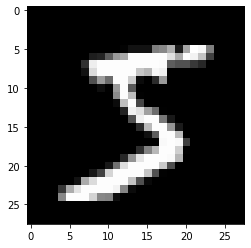

In [4]:
img,label = dataset[0]
print(img.shape)
plt.imshow(img[0], cmap="gray")

Now we split indices for 20% validation set

In [6]:
def split_indices(n, val_pct):
    n_val = int(n*val_pct)
    idxs = np.random.permutation(n)
    return idxs[n_val:], idxs[:n_val] 

In [7]:
train_indices, val_indices = split_indices(len(dataset), 0.2)
len(train_indices),len(val_indices)

(48000, 12000)

## Making DataLoader

In [8]:
batch_size = 100

train_sample = SubsetRandomSampler(train_indices)
train_dl = DataLoader(dataset, batch_size, sampler=train_sample)

valid_sample = SubsetRandomSampler(val_indices)
valid_dl = DataLoader(dataset, batch_size, sampler=valid_sample)


## Model

We are now ready to define our model. As discussed above, we'll create a neural network with one hidden layer. Here's what that means:

* Instead of using a single `nn.Linear` object to transform a batch of inputs (pixel intensities) into outputs (class probabilities), we'll use two `nn.Linear` objects. Each of these is called a _layer_ in the network. 

* The first layer (also known as the hidden layer) will transform the input matrix of shape `batch_size x 784` into an intermediate output matrix of shape `batch_size x hidden_size`. The parameter `hidden_size` can be configured manually (e.g., 32 or 64).

* We'll then apply a non-linear *activation function* to the intermediate outputs. The activation function transforms individual elements of the matrix.

* The result of the activation function, which is also of size `batch_size x hidden_size`, is passed into the second layer (also known as the output layer).  The second layer transforms it into a matrix of size `batch_size x 10`. We can use this output to compute the loss and adjust weights using gradient descent.


As discussed above, our model will contain one hidden layer. Here's what it looks like visually:
<center>
<img src="https://i.imgur.com/eN7FrpF.png" width="480">
</center>

Let's define the model by extending the `nn.Module` class from PyTorch.

In [9]:
import torch.nn.functional as F
import torch.nn as nn

We will now create a custom class to set our layers as well as avoid the problem that we faced regarding the shape of our image tensor. 

In [16]:
class MnistModel(nn.Module):
    def __init__(self,in_size, hidden_size, out_size):
        super().__init__()
        # hidden layer
        self.linear1 = nn.Linear(in_size, hidden_size)
        # output layer
        self.linear2 = nn.Linear(hidden_size, out_size)
        
    def forward(self, xb):
        # flatter tensor
        xb = xb.view(xb.size(0),-1)
        # apply hidden layer
        out = self.linear1(xb)
        # apply ReLU
        out = F.relu(out)
        # apply out layer
        out = self.linear2(out)
        return out
    

In [17]:
# now we will create a model with hidden size = 32
input_size = 784
num_classes = 10

model = MnistModel(input_size, 32, out_size = num_classes)

Getting an output

In [21]:
for images, labels in train_dl:
    outputs = model(images)
    loss = F.cross_entropy(outputs, labels)
    print("Loss:",loss.item())
    break;

print("Outputs Size:",outputs.shape)
print("Outputs egs:",outputs[:2])

Loss: 2.3176956176757812
Outputs Size: torch.Size([100, 10])
Outputs egs: tensor([[-0.0617,  0.0867,  0.0536,  0.1817,  0.0318,  0.2732, -0.1201, -0.0592,
         -0.1365, -0.1753],
        [-0.1375,  0.1219, -0.0791,  0.2446,  0.0974,  0.2420, -0.0980,  0.0808,
         -0.1921, -0.1883]], grad_fn=<SliceBackward0>)


## Using a GPU

To check if GPU is available and we have cuda drivers installed we check by the following code. 

In [30]:
torch.cuda.is_available()

True

Now we need to assign a device that will use cuda or cpu depending on what is available

In [31]:
def get_default_device():
    if torch.cuda.is_available():
        return torch.device('cuda')
    else:
        return torch.device('cpu')

In [32]:
device = get_default_device()
device

device(type='cuda')

#### Moving Data and Model to Device

Once the device is created, we will move our data and model to the device

In [33]:
def to_device(data, device):
    if isinstance(data,(list,tuple)):
        return [to_device(x,device) for x in data]
    return data.to(device, non_blocking=True)

In [34]:
for images, labels in train_dl:
    print(images.shape)
    images = to_device(images, device)
    print(images.device)
    break

torch.Size([100, 1, 28, 28])
cuda:0


## Device Data Loader

It is usually a bad idea to put everything into the GPU at once. It is not ideal to put 10s of GB of data onto the GPU. Hence we use a class that loads them onto the GPU as and when required. 
There is no need to remove from GPU as it has an automatic garbage collection system, to remove items not in use.

In [40]:
class DeviceDataLoader():
    def __init__(self, dl, device):
        # creating objects for data loader and device but not putting them on the GPU
        self.dl = dl
        self.device = device
    
    def __iter__(self):
        # used to put data onto device from dataloader one at a time 
        for b in self.dl:
            yield to_device(b,self.device)
        # yield is used to return like a generator. 
        # Meaning that it will execute on for loop using memory and stop all other executions and then use the same memory 
        # for the other element of for loop
    
    def __len__(self):
        print(len(self.dl))

In [41]:
train_dl = DeviceDataLoader(train_dl, device)
valid_dl = DeviceDataLoader(valid_dl, device)

To check if tensors have been moved onto our device we can do it by

In [42]:
for xb,yb in valid_dl:
    print(xb.device)
    print(yb)
    break

cuda:0
tensor([0, 2, 7, 2, 7, 6, 5, 7, 8, 3, 7, 7, 1, 4, 4, 3, 3, 7, 9, 4, 1, 5, 6, 0,
        6, 6, 1, 9, 8, 3, 6, 2, 8, 0, 7, 3, 8, 2, 0, 9, 7, 1, 7, 3, 3, 3, 4, 3,
        7, 6, 8, 0, 5, 3, 7, 0, 2, 3, 3, 9, 5, 0, 2, 6, 2, 2, 8, 9, 0, 1, 9, 8,
        6, 2, 4, 0, 7, 9, 0, 2, 6, 6, 6, 6, 7, 6, 3, 6, 7, 9, 9, 2, 8, 8, 8, 8,
        2, 9, 5, 0], device='cuda:0')


## Training the Model

We will use the loss_batch, evaluate, and fit that we used in logistic regression again. They will be exactly same

In [57]:
def loss_batch(model, loss_fn, xb,yb, opt=None, metric = None):
    pred = model(xb)
    loss = loss_fn(pred, yb)
    
    if opt is not None:
        loss.backward()
        opt.step()
        opt.zero_grad()
        
    metric_result = None
    if metric is not None:
        metric_result = metric(pred,yb)
        
    return loss.item(), len(xb), metric_result
        

In [53]:
def evaluate(model, loss_fn, valid_dl, metric=None):
    with torch.no_grad():
        results = [loss_batch(model,loss_fn,xb,yb,metric = metric) for xb,yb in valid_dl]
        
        losses, nums, metrics = zip(*results)
        
        total = np.sum(nums)
        
        avg_loss = np.sum(np.multiply(losses,nums))/total 
        avg_metric = None
        
        if metric is not None:
            avg_metric = np.sum(np.multiply(metrics,nums))/total 
        
        return avg_loss, total, avg_metric
        

In [61]:
def fit(epochs, lr, model, loss_fn, train_dl, valid_dl, metric=None, opt_fn = None):
    losses, metrics = [], []
    
    # Making the optimizer 
    if opt_fn is None: 
        opt_fn = torch.optim.SGD
    opt = opt_fn(model.parameters(), lr= lr)
    
    # looping over epochs
    for epoch in range(epochs):
        # training
        for xb, yb in train_dl:
            loss_batch(model, loss_fn, xb, yb, opt = opt)
    
        # Evaluation
        result = evaluate(model, loss_fn, valid_dl, metric)
        val_loss, total, val_metric = result
        
        losses.append(val_loss)
        metrics.append(val_metric)
        
        if metric is None:
            print ('Epoch [{}/{}], Loss: {:.4f}'.format (epoch+1, epochs, val_loss))
        else:
            print ('Epoch [{}/{}], Loss: {:.4f}, {}: {:.4f}'.format (epoch+1, epochs, val_loss, metric.__name__, val_metric))
        
    return losses, metrics


In [55]:
def accuracy(outputs, labels):
    _,preds  = torch.max(outputs,dim=1)
    return torch.sum(preds==labels).item()/len(preds)

In [56]:
# We put the model onto the gpu
model = MnistModel(input_size, 32, out_size=num_classes)
to_device(model,device)

MnistModel(
  (linear1): Linear(in_features=784, out_features=32, bias=True)
  (linear2): Linear(in_features=32, out_features=10, bias=True)
)

In [58]:
val_loss, total, val_acc = evaluate(model, F.cross_entropy, valid_dl, accuracy)
print("Loss:",val_loss,"Accuracy:", val_acc)

Loss: 2.310441529750824 Accuracy: 0.11291666666666667


Initial accuracy is 10% cz it is randomly initialized. 

In [62]:
loss1, metric1 = fit(5, 0.5,model, F.cross_entropy, train_dl, valid_dl, metric=accuracy)

Epoch [1/5], Loss: 0.2311, accuracy: 0.9313
Epoch [2/5], Loss: 0.1949, accuracy: 0.9442
Epoch [3/5], Loss: 0.1629, accuracy: 0.9534
Epoch [4/5], Loss: 0.1507, accuracy: 0.9568
Epoch [5/5], Loss: 0.1413, accuracy: 0.9613


It jumped to 93% accuracy in just one epoch and ended with 96% accuracy by the end of only 5 epochs!

In [63]:
loss2, metric2 = fit(5, 0.1,model, F.cross_entropy, train_dl, valid_dl, metric=accuracy)


Epoch [1/5], Loss: 0.1239, accuracy: 0.9657
Epoch [2/5], Loss: 0.1219, accuracy: 0.9653
Epoch [3/5], Loss: 0.1228, accuracy: 0.9650
Epoch [4/5], Loss: 0.1205, accuracy: 0.9672
Epoch [5/5], Loss: 0.1210, accuracy: 0.9660


We can see that it jumped to about 96.6%

Text(0, 0.5, 'accuracy')

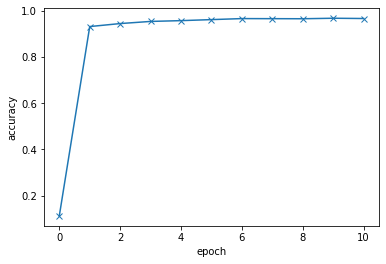

In [67]:
# We can have an accuracy graph as 
accuracies = [val_acc] + metric1 + metric2
plt.plot(accuracies, "-x")
plt.xlabel("epoch")
plt.ylabel("accuracy")


We can now see that the plot flattens around 95-96%. To improve the accuracy we can either
1. Increase size of hidden batch
2. Add more hidden layers


## Testing

In [85]:
# Testing the data
test_dataset = MNIST(root= "data/", train=False, transform = ToTensor())

In [86]:
# covert to dataloader 
test_dl = DataLoader(test_dataset, batch_size = batch_size)

In [87]:
# move dataset to device
test_dl = DeviceDataLoader(test_dl, device)

In [88]:
for xb, yb in test_dl:
    test_loss,_,test_acc = evaluate(model, F.cross_entropy, test_dl, accuracy)
    print(test_acc)
    break;

0.9678
